# Aug 8, 2025: dummy solution landscape

In [23]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob

# import arviz as az
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [24]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [25]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [26]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [27]:
args.dc, args.sbm = True, 'd'
args.nested = args.sbm == 'h'

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-dc-d'

In [28]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f02e5ae7d90>

In [29]:
indiv_files = sorted(glob.glob(f'{SBM_path}/*/{SBM}/B-224/desc-partition-modes.pkl'))
indiv_file = indiv_files[0]

with open(indiv_file, 'rb') as f:
    df, = pickle.load(f)

In [30]:
df

In [31]:
modes = df.copy()
modes

In [32]:
omegas = np.array([mode.get_M() for mode in modes])
omegas = omegas / np.sum(omegas)
omegas = np.round(omegas, decimals=3)
omegas

array([0.224, 0.211, 0.183, 0.116, 0.073, 0.064, 0.058, 0.057, 0.013])

In [33]:
sigmas = np.array([mode.posterior_cdev() for mode in modes])
sigmas = np.round(sigmas, decimals=3)
sigmas

array([0.03 , 0.025, 0.023, 0.037, 0.032, 0.043, 0.042, 0.028, 0.061])

In [34]:
df = pd.DataFrame(dict(
    mode_id=np.arange(0, len(modes)),
    mode=modes,
    omega=omegas,
    sigma=sigmas,
))
df

mode_id                                               mode  omega  sigma
0        0  <graph_tool.inference.partition_modes.Partitio...  0.224  0.030
1        1  <graph_tool.inference.partition_modes.Partitio...  0.211  0.025
2        2  <graph_tool.inference.partition_modes.Partitio...  0.183  0.023
3        3  <graph_tool.inference.partition_modes.Partitio...  0.116  0.037
4        4  <graph_tool.inference.partition_modes.Partitio...  0.073  0.032
5        5  <graph_tool.inference.partition_modes.Partitio...  0.064  0.043
6        6  <graph_tool.inference.partition_modes.Partitio...  0.058  0.042
7        7  <graph_tool.inference.partition_modes.Partitio...  0.057  0.028
8        8  <graph_tool.inference.partition_modes.Partitio...  0.013  0.061

<Axes: >

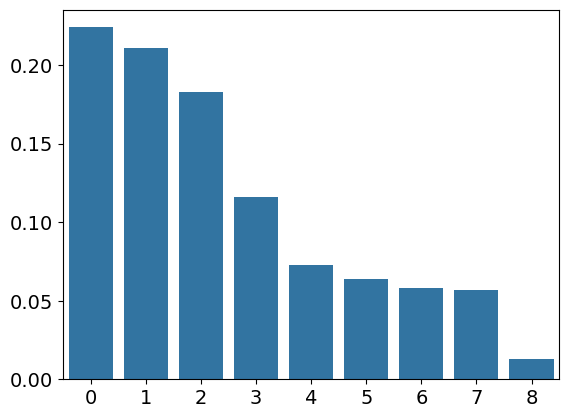

In [35]:
sns.barplot(df['omega'].values)

In [36]:
# HOW MANY MODES DO YOU WANT TO DISPLAY??
modes_ = [0, 1, 2, 3, 4, 5, 6, 7, 8]

In [37]:
bs = []
for idx, row in df.iterrows():
    if idx not in modes_: continue
    mode = row['mode']
    bs += random.sample(list(row['mode'].get_partitions().values()), int(np.round(200*row['omega'])))
len(bs)

201

In [38]:
from scipy.stats import entropy

def variation_of_information(x, y):
    """
    Compute the Variation of Information (VI) between two partitions.
    Parameters:
        x, y: 1D integer arrays (same length)
    Returns:
        vi: float
    """
    x = np.asarray(x)
    y = np.asarray(y)
    assert x.shape == y.shape

    n = len(x)
    x_labels, x_ids = np.unique(x, return_inverse=True)
    y_labels, y_ids = np.unique(y, return_inverse=True)

    # Contingency table
    contingency = np.zeros((len(x_labels), len(y_labels)), dtype=np.int32)
    np.add.at(contingency, (x_ids, y_ids), 1)

    pij = contingency / n
    pi = pij.sum(axis=1, keepdims=True)  # shape (R, 1)
    pj = pij.sum(axis=0, keepdims=True)  # shape (1, S)

    # Mask for nonzero joint probabilities
    nz = pij > 0

    mi = np.sum(pij[nz] * np.log(pij[nz] / (pi @ pj)[nz]))
    h_x = entropy(pi.ravel())
    h_y = entropy(pj.ravel())

    return h_x + h_y - 2 * mi

def compute_distance_matrix(partitions, metric_fn):
    """
    Compute a symmetric pairwise distance matrix from a list of partitions.
    Parameters:
        partitions: list of 1D arrays
        metric_fn: function like variation_of_information or reduced_mutual_information
    Returns:
        dist_matrix: 2D numpy array
    """
    M = len(partitions)
    dist = np.zeros((M, M))
    for i in tqdm(range(M)):
        for j in range(i + 1, M):
            d = metric_fn(partitions[i], partitions[j])
            dist[i, j] = dist[j, i] = d
    return dist

In [39]:
vi_matrix = compute_distance_matrix(bs, variation_of_information)
vi_matrix.shape

100%|██████████| 201/201 [00:28<00:00,  7.00it/s]


(201, 201)

<Axes: >

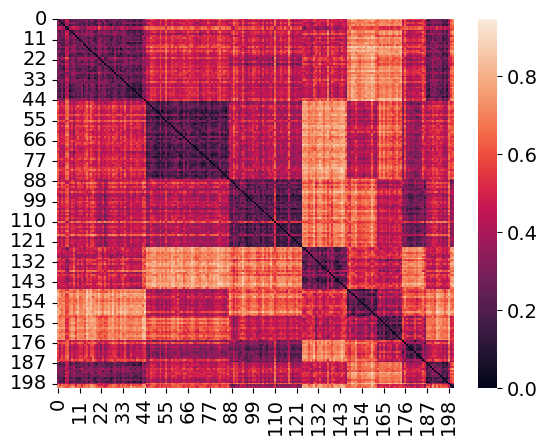

In [40]:
sns.heatmap(vi_matrix)

In [41]:
from umap import UMAP 

reducer = UMAP(metric=variation_of_information, n_neighbors=2, min_dist=0.1, random_state=args.SEED)
embedding = reducer.fit_transform(vi_matrix)
embedding

array([[ 8.51356792e+00, -6.23936558e+00],
       [ 7.87893486e+00, -6.62538671e+00],
       [-1.63844430e+00, -1.08042724e-01],
       [ 7.84503174e+00, -6.76232767e+00],
       [-1.32983673e+00,  1.02247976e-01],
       [-1.55863035e+00,  4.79639202e-01],
       [ 8.14907360e+00, -7.04764223e+00],
       [ 8.47646713e+00, -6.86431456e+00],
       [ 8.33372784e+00, -6.87341022e+00],
       [-3.88506532e+00, -7.25734979e-02],
       [ 1.55973234e+01,  5.86681843e+00],
       [-1.35362959e+00,  4.34150040e-01],
       [-1.29230654e+00,  8.92776102e-02],
       [ 8.35593033e+00, -6.93640184e+00],
       [-2.26730394e+00, -2.48653740e-01],
       [ 1.55381699e+01,  5.93306208e+00],
       [ 7.97377491e+00, -6.97147655e+00],
       [-2.04937577e+00, -4.43589211e-01],
       [-4.86830616e+00,  8.43989372e-01],
       [ 8.08582211e+00, -6.82909966e+00],
       [ 1.24195766e+01,  1.52735987e+01],
       [-4.53379822e+00, -2.56541550e-01],
       [ 8.02272797e+00, -6.62031126e+00],
       [-3.

<Axes: >

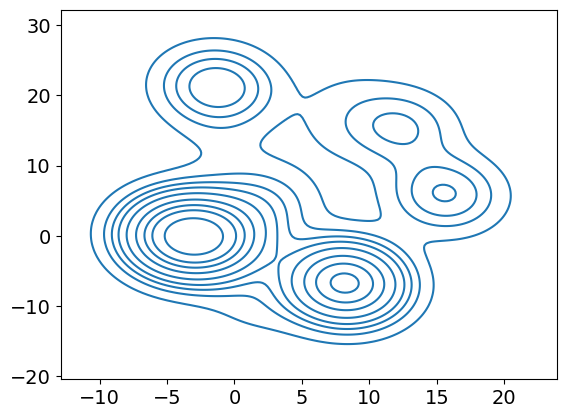

In [42]:
sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1])

In [43]:
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting

# Assume embedding is (M, 2)
x, y = embedding[:, 0], embedding[:, 1]

# Step 1: Fit KDE in 2D
xy = np.vstack([x, y])
kde = gaussian_kde(xy, bw_method='scott')  # or adjust bandwidth

# Step 2: Evaluate KDE on grid
x_min, x_max = x.min() - 3.0, x.max() + 3.0
y_min, y_max = y.min() - 3.0, y.max() + 3.0
x_grid, y_grid = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]
grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
z = kde(grid_coords).reshape(x_grid.shape)

In [44]:
import plotly.graph_objects as go

vert_exag = 2.0
z_plot = ((z - z.min()) / (z.max() - z.min() + 1e-12)) ** 0.8 * vert_exag

fig = go.Figure(go.Surface(
    x=x_grid, y=y_grid, z=z_plot,
    colorscale='Blues',
    showscale=False,
    lighting=dict(ambient=1.0, diffuse=0.0, specular=0.0, roughness=1.0, fresnel=0.0)  # flat, no glints
))
fig.update_layout(
    width=900, height=700,
    scene=dict(
        xaxis=dict(visible=False), yaxis=dict(visible=False), zaxis=dict(visible=False),
        aspectratio=dict(x=1, y=1, z=vert_exag/4),  # tweak z feel independent of data scale
        bgcolor='white',
        camera=dict(eye=dict(x=1.6, y=1.6, z=1.2))
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.show()

---

dummy E_m calculations

In [48]:
probs = np.array([1.00, 0.00])
Em = np.exp(stats.entropy(probs))
probs.sum(), Em

(np.float64(1.0), np.float64(1.0))

In [49]:
probs = np.array([0.99, 0.01])
Em = np.exp(stats.entropy(probs))
probs.sum(), Em

(np.float64(1.0), np.float64(1.0575993064679887))

In [50]:
probs = np.array([0.75, 0.2, 0.03, 0.02])
Em = np.exp(stats.entropy(probs))
probs.sum(), Em

(np.float64(1.0), np.float64(2.0566662236702395))

In [54]:
probs = np.array([0.50, 0.45, 0.03, 0.02])
Em = np.exp(stats.entropy(probs))
probs.sum(), Em

(np.float64(1.0), np.float64(2.4335211723080716))

In [57]:
probs = np.array([0.25, 0.24, 0.18, 0.17, 0.16])
Em = np.exp(stats.entropy(probs))
probs.sum(), Em

(np.float64(1.0), np.float64(4.914504477080852))